#BA820 Project M1 — Alone (TV Show)
* Team: A1_08
* Datasets used: `survivalists.csv`, `loadouts.csv`, `episodes.csv`
* Goal: Conduct preliminary exploratory analysis to understand the data, surface patterns/anomalies, and motivate domain/business questions for unsupervised exploration.

##Data Overview, Standardization, and Quality Assessment


We focus on three tables that directly support individual-level behavior, strategic decision-making, and audience engagement:

* `survivalists.csv`: participant demographics and outcomes (days lasted, exit reason, medical evacuation)

* `loadouts.csv`: each survivalist’s 10-item selection, reflecting strategy under constraint

* `episodes.csv`: episode-level engagement metrics (viewers, IMDb rating)

Season-level environmental data (`seasons.csv`) was reviewed but not used in the primary exploratory analysis due to its limited sample size and largely contextual role relative to individual-level behavior and episode-level engagement.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
BASE_URL = "https://raw.githubusercontent.com/Marcusshi/BA820-A1-08/main/data/alone_tv_show/"

urls = {
    "survivalists": BASE_URL + "survivalists.csv",
    "loadouts": BASE_URL + "loadouts.csv",
    "episodes": BASE_URL + "episodes.csv"
}

In [ ]:
survivalists = pd.read_csv(urls["survivalists"])
loadouts = pd.read_csv(urls["loadouts"])
episodes = pd.read_csv(urls["episodes"])

In [ ]:
print("Survivalists:", survivalists.shape)
print("Loadouts:", loadouts.shape)
print("Episodes:", episodes.shape)

Survivalists: (94, 16)
Loadouts: (940, 6)
Episodes: (98, 11)


In [ ]:
survivalists.head()

,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,reason_tapped_out,reason_category,team,day_linked_up,profession,url
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,NaN,NaN,NaN,NaN,Corrections Officer,alan-kay
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,Lost the mind game,Family / personal,NaN,NaN,Outdoor Gear Retailer,sam-larson
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,Realized he should actually be around for his ...,Family / personal,NaN,NaN,Butcher,mitch-mitchell
3,1,Lucas Miller,32,Male,Quasqueton,Iowa,United States,4,39,False,Felt content with what he had done,Family / personal,NaN,NaN,Survivalist and Wildlife Therapist/Natural Hea...,lucas-miller
4,1,Dustin Feher,37,Male,Pittsburgh,Pennsylvania,United States,5,8,False,Fear of storm,Family / personal,NaN,NaN,Carpenter,dustin-feher


In [ ]:
loadouts.head()

,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag
3,US,1,Alan Kay,4,Large 2-quart pot,Pot
4,US,1,Alan Kay,5,Ferro rod,Ferro rod


In [ ]:
episodes.head()

,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0
3,US,1,4,4,Stalked,2015-07-09,2.082,"Hunger, love, pain, fear are some of those inn...",Albert Einstein,7.7,104.0
4,US,1,5,5,Winds of Hell,2015-07-16,2.082,"The strong survive, but the courageous triumph.",Michael Scott,7.6,99.0


###Datasets info

In [ ]:
import io
from IPython.display import display, HTML

def df_info_to_str(df):
    buffer = io.StringIO()
    df.info(buf=buffer)
    return buffer.getvalue()

In [ ]:
surv_info = df_info_to_str(survivalists)
load_info = df_info_to_str(loadouts)
epis_info = df_info_to_str(episodes)

In [ ]:
html = f"""
<div style="display:flex; gap:20px; font-family:monospace; font-size:12px;">
  <div style="flex:1;">
    <h4>survivalists.csv</h4>
    <pre>{surv_info}</pre>
  </div>
  <div style="flex:1;">
    <h4>loadouts.csv</h4>
    <pre>{load_info}</pre>
  </div>
  <div style="flex:1;">
    <h4>seasons.csv</h4>
    <pre>{epis_info}</pre>
  </div>
</div>
"""

display(HTML(html))

### Data Standardization and Initial Data Quality Check

We first standardize column names across all datasets by converting them to lowercase and replacing spaces or hyphens with underscores. This ensures consistent naming conventions and simplifies downstream merging and analysis.

Next, we conduct a quick data quality check for each dataset, examining:
- Dataset shape (number of rows and columns),
- Data types of each variable,
- Presence of duplicate rows.

This step helps us understand the structure and completeness of the data, identify variables with substantial missingness, and confirm that no duplicated records are present before proceeding with exploratory analysis.

###Missing Data Notes
* Missing values in the survivalists dataset are largely structural rather than indicative of data quality issues. Exit-related fields (reason_tapped_out, reason_category) are missing only for winners, for whom these variables are not applicable. Team-related fields contain missing values for most observations because the team format was exclusive to Season 4. No imputation was performed, as these missing values carry substantive meaning.  
* We also convert air_date to a datetime format to enable episode-level temporal trend analysis.

In [ ]:
def clean_cols(df):
    df.columns = (
        df.columns.str.strip()
                 .str.lower()
                 .str.replace(" ", "_")
                 .str.replace("-", "_")
    )
    return df

survivalists = clean_cols(survivalists)
loadouts     = clean_cols(loadouts)
episodes     = clean_cols(episodes)

def df_check(df, name):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("dtypes:\n", df.dtypes)
    miss = (df.isna().mean().sort_values(ascending=False) * 100).round(1)
    print("\nmissing % (top):\n", miss.head(12))
    print("\nduplicated rows:", df.duplicated().sum())
    display(df.head(3))

df_check(survivalists, "survivalists")
df_check(loadouts, "loadouts")
df_check(episodes, "episodes")


=== survivalists ===
shape: (94, 16)
dtypes:
 season                   int64
name                    object
age                      int64
gender                  object
city                    object
state                   object
country                 object
result                   int64
days_lasted              int64
medically_evacuated       bool
reason_tapped_out       object
reason_category         object
team                    object
day_linked_up          float64
profession              object
url                     object
dtype: object

missing % (top):
 day_linked_up        91.5
team                 85.1
reason_tapped_out    10.6
reason_category      10.6
state                 1.1
season                0.0
age                   0.0
name                  0.0
result                0.0
country               0.0
city                  0.0
gender                0.0
dtype: float64

duplicated rows: 0


,season,name,age,gender,city,state,country,result,days_lasted,medically_evacuated,reason_tapped_out,reason_category,team,day_linked_up,profession,url
0,1,Alan Kay,40,Male,Blairsville,Georgia,United States,1,56,False,NaN,NaN,NaN,NaN,Corrections Officer,alan-kay
1,1,Sam Larson,22,Male,Lincoln,Nebraska,United States,2,55,False,Lost the mind game,Family / personal,NaN,NaN,Outdoor Gear Retailer,sam-larson
2,1,Mitch Mitchell,34,Male,Bellingham,Massachusetts,United States,3,43,False,Realized he should actually be around for his ...,Family / personal,NaN,NaN,Butcher,mitch-mitchell



=== loadouts ===
shape: (940, 6)
dtypes:
 version          object
season            int64
name             object
item_number       int64
item_detailed    object
item             object
dtype: object

missing % (top):
 version          0.0
season           0.0
name             0.0
item_number      0.0
item_detailed    0.0
item             0.0
dtype: float64

duplicated rows: 0


,version,season,name,item_number,item_detailed,item
0,US,1,Alan Kay,1,Saw,Saw
1,US,1,Alan Kay,2,Axe,Axe
2,US,1,Alan Kay,3,Sleeping bag,Sleeping bag



=== episodes ===
shape: (98, 11)
dtypes:
 version                    object
season                      int64
episode_number_overall      int64
episode                     int64
title                      object
air_date                   object
viewers                   float64
quote                      object
author                     object
imdb_rating               float64
n_ratings                 float64
dtype: object

missing % (top):
 viewers                   15.3
n_ratings                  5.1
imdb_rating                5.1
episode_number_overall     0.0
season                     0.0
version                    0.0
episode                    0.0
air_date                   0.0
title                      0.0
author                     0.0
quote                      0.0
dtype: float64

duplicated rows: 0


,version,season,episode_number_overall,episode,title,air_date,viewers,quote,author,imdb_rating,n_ratings
0,US,1,1,1,And So It Begins,2015-06-18,1.582,I went to the woods because I wished to live d...,Henry David Thoreau,7.5,135.0
1,US,1,2,2,Of Wolf and Man,2015-06-25,1.697,If you live among wolves you have to act like ...,Nikita Khrushchev,7.7,110.0
2,US,1,3,3,The Talons of Fear,2015-07-02,1.864,Extinction is the rule. Survival is the except...,Carl Sagan,7.7,104.0


In [ ]:
#converting air_date to a datetime format to enable episode-level temporal trend analysis.
episodes["air_date"] = pd.to_datetime(episodes["air_date"], errors="coerce")

##EDA 1 — Survival Outcomes

- We begin with the primary outcome: days_lasted, which captures how long each participant remained in the competition.

In [ ]:
BLUE = "#1f77b4"
BLUE_DARK = "#0b3d91"
BLUE_LIGHT = "#cfe8ff"
GRID = "#e6e6e6"

def set_blue_theme():
    plt.rcParams.update({
        "figure.figsize": (10, 4.8),
        "figure.dpi": 120,
        "axes.facecolor": "white",
        "axes.edgecolor": "#dddddd",
        "axes.linewidth": 1.0,
        "axes.grid": True,
        "grid.color": GRID,
        "grid.linestyle": "-",
        "grid.linewidth": 0.8,
        "axes.axisbelow": True,
        "font.size": 11,
        "axes.titlesize": 15,
        "axes.titleweight": "bold",
        "axes.labelsize": 12,
        "xtick.labelsize": 10.5,
        "ytick.labelsize": 10.5,
        "legend.frameon": False,
    })

def polish_ax(ax, title=None, xlabel=None, ylabel=None):
    if title:
        ax.set_title(title, color=BLUE_DARK, pad=12)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    ax.grid(True, axis="y", alpha=0.9)
    ax.grid(False, axis="x")

set_blue_theme()

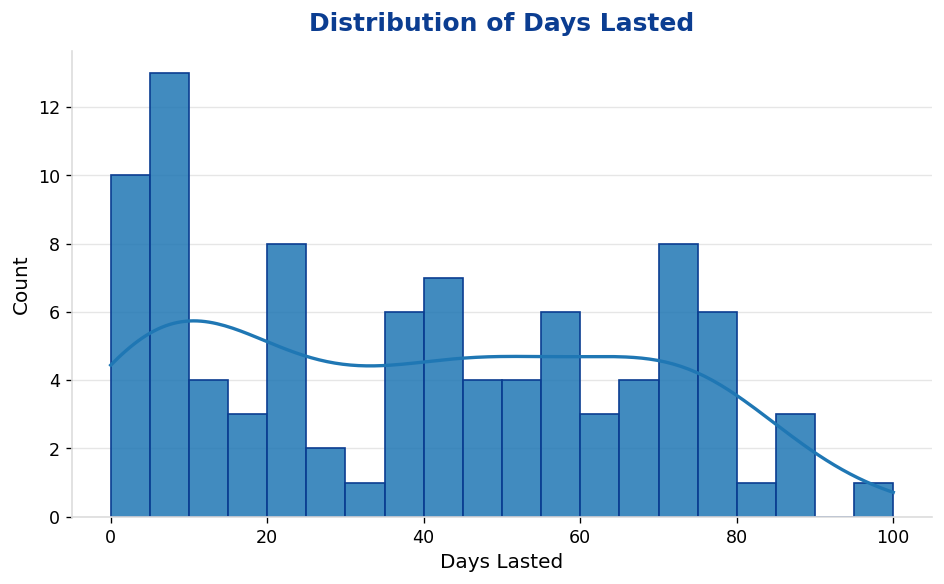

In [ ]:
plt.figure(figsize=(8, 5), dpi=120)

sns.histplot(
    survivalists["days_lasted"].dropna(),
    bins=20,
    kde=True,
    color=BLUE,
    edgecolor=BLUE_DARK,
    alpha=0.85,
    line_kws={
        "color": BLUE_DARK,
        "linewidth": 2
    }
)

plt.title(
    "Distribution of Days Lasted",
    fontsize=15,
    fontweight="bold",
    color=BLUE_DARK,
    pad=12
)
plt.xlabel("Days Lasted", fontsize=12)
plt.ylabel("Count", fontsize=12)


ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


ax.grid(True, axis="y", color=GRID, linewidth=0.8)
ax.grid(False, axis="x")

plt.tight_layout()
plt.show()

**EDA Insights — Distribution of Days Lasted**

- The distribution is highly **right-skewed**, with many participants exiting early and a smaller group surviving much longer.
- Evidence of **multiple density peaks** suggests the presence of distinct survival regimes rather than a single continuous pattern.
- The long tail indicates that extreme survival outcomes are driven by a few participants, motivating further analysis of **outliers and clustering**.

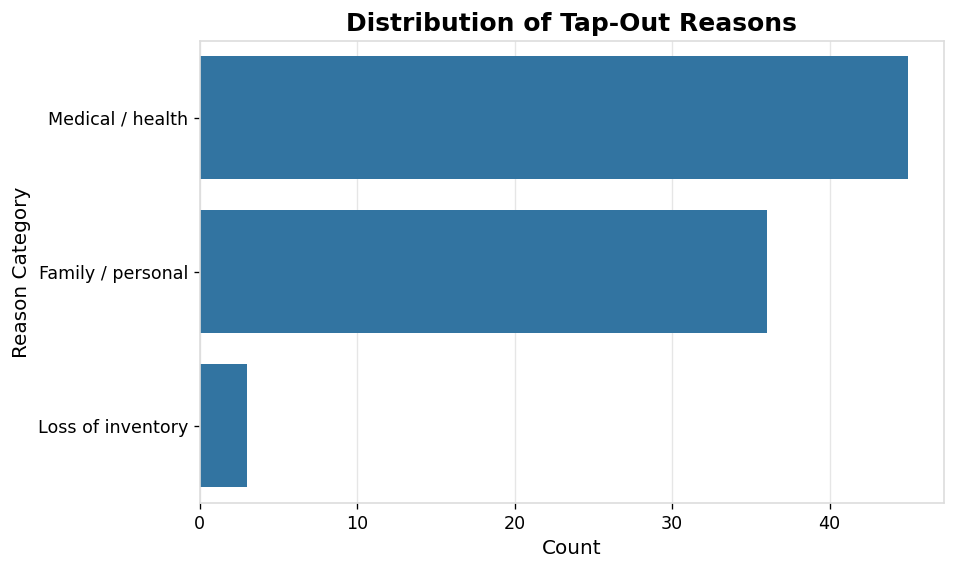

In [ ]:
plt.figure(figsize=(8,5))
sns.countplot(
    y="reason_category",
    data=survivalists,
    order=survivalists["reason_category"].value_counts().index
)
plt.title("Distribution of Tap-Out Reasons")
plt.xlabel("Count")
plt.ylabel("Reason Category")
plt.show()


In [ ]:
survivalists["medically_evacuated"].value_counts(dropna=False)

,count
medically_evacuated,
False,69
True,25


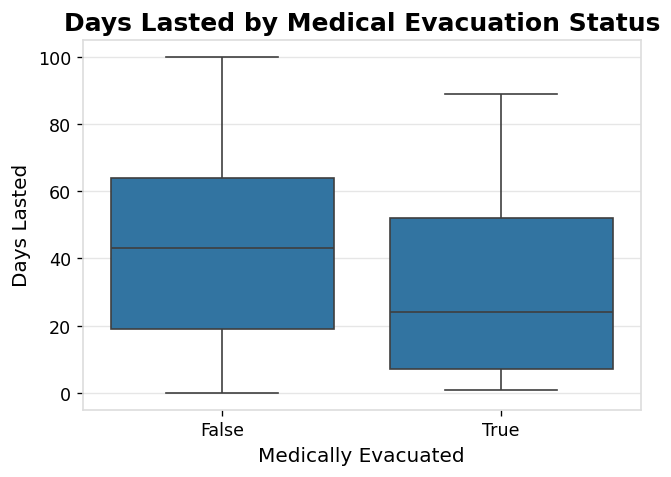

In [ ]:
plt.figure(figsize=(6,4))
sns.boxplot(
    x="medically_evacuated",
    y="days_lasted",
    data=survivalists
)
plt.title("Days Lasted by Medical Evacuation Status")
plt.xlabel("Medically Evacuated")
plt.ylabel("Days Lasted")
plt.show()


**EDA Insights — Days Lasted by Medical Evacuation Status**

- Participants who were medically evacuated tend to have **shorter survival durations**, with a noticeably lower median compared to those who were not evacuated.
- The medically evacuated group shows **greater concentration at lower survival days**, indicating a distinct early-failure pathway.
- In contrast, non-evacuated participants exhibit a wider spread and higher upper range, suggesting that **long survival is more common among those who exit voluntarily or win**.


/tmp/ipython-input-4243219058.py:11: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


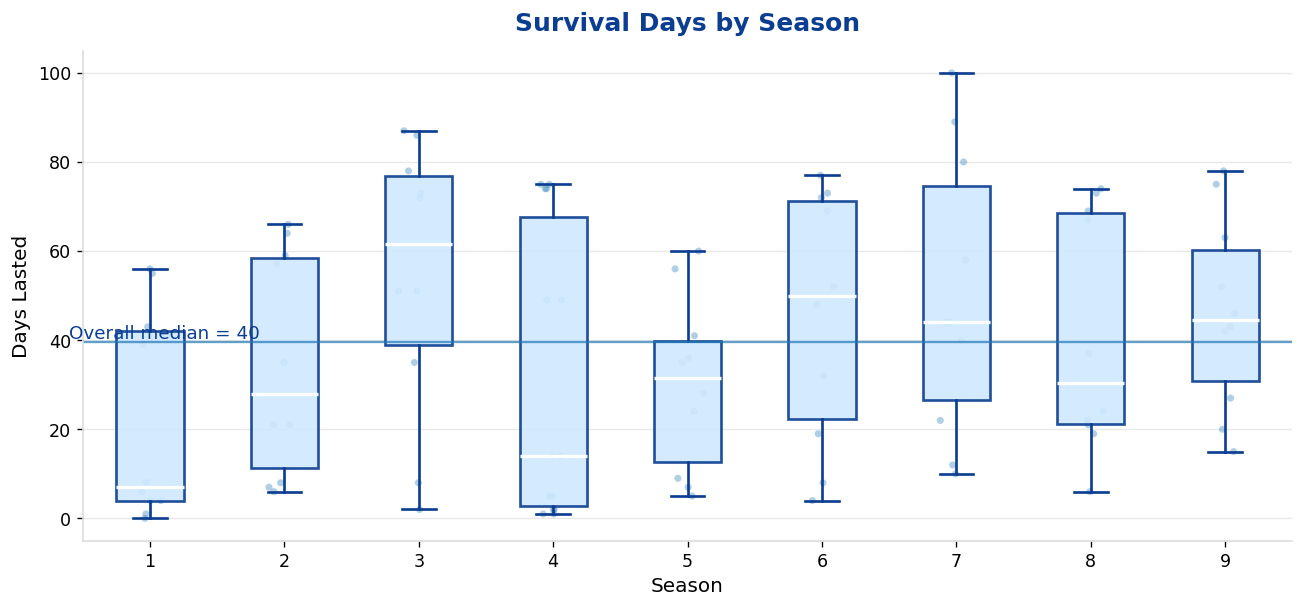

In [ ]:
tmp = survivalists.copy()
tmp["days_lasted"] = pd.to_numeric(tmp["days_lasted"], errors="coerce")
tmp = tmp.dropna(subset=["season", "days_lasted"])


season_order = sorted(tmp["season"].unique())
data = [tmp.loc[tmp["season"] == s, "days_lasted"].values for s in season_order]

fig, ax = plt.subplots(figsize=(11, 5.2), dpi=120)

bp = ax.boxplot(
    data,
    labels=[str(s) for s in season_order],
    patch_artist=True,
    showfliers=False,
    medianprops=dict(color="white", linewidth=2),
    whiskerprops=dict(color=BLUE_DARK, linewidth=1.6),
    capprops=dict(color=BLUE_DARK, linewidth=1.6),
    boxprops=dict(edgecolor=BLUE_DARK, linewidth=1.6),
)

for box in bp["boxes"]:
    box.set_facecolor(BLUE_LIGHT)
    box.set_alpha(0.9)


rng = np.random.default_rng(7)
for i, s in enumerate(season_order, start=1):
    y = tmp.loc[tmp["season"] == s, "days_lasted"].values
    x = i + rng.normal(0, 0.06, size=len(y))
    ax.scatter(x, y, s=18, alpha=0.35, color=BLUE, edgecolors="none")

polish_ax(
    ax,
    title="Survival Days by Season",
    xlabel="Season",
    ylabel="Days Lasted",
)


overall_median = tmp["days_lasted"].median()
ax.axhline(overall_median, color=BLUE, linewidth=1.4, alpha=0.7)
ax.text(0.4, overall_median, f"Overall median = {overall_median:.0f}", color=BLUE_DARK, va="bottom")

plt.tight_layout()
plt.show()

**EDA Insights — Survival Days by Season**

- Survival days vary markedly across seasons, showing strong **between-season heterogeneity**.
- Several seasons exhibit **long-tailed distributions**, where a few participants survive much longer than most.
- While many season medians cluster near the overall median (~40 days), deviations suggest **season-specific conditions** meaningfully shape outcomes.
- Season 4 stands out with a notably lower median survival time and a much wider spread than most other seasons, indicating a **structurally distinct survival pattern** rather than a simple shift in difficulty.

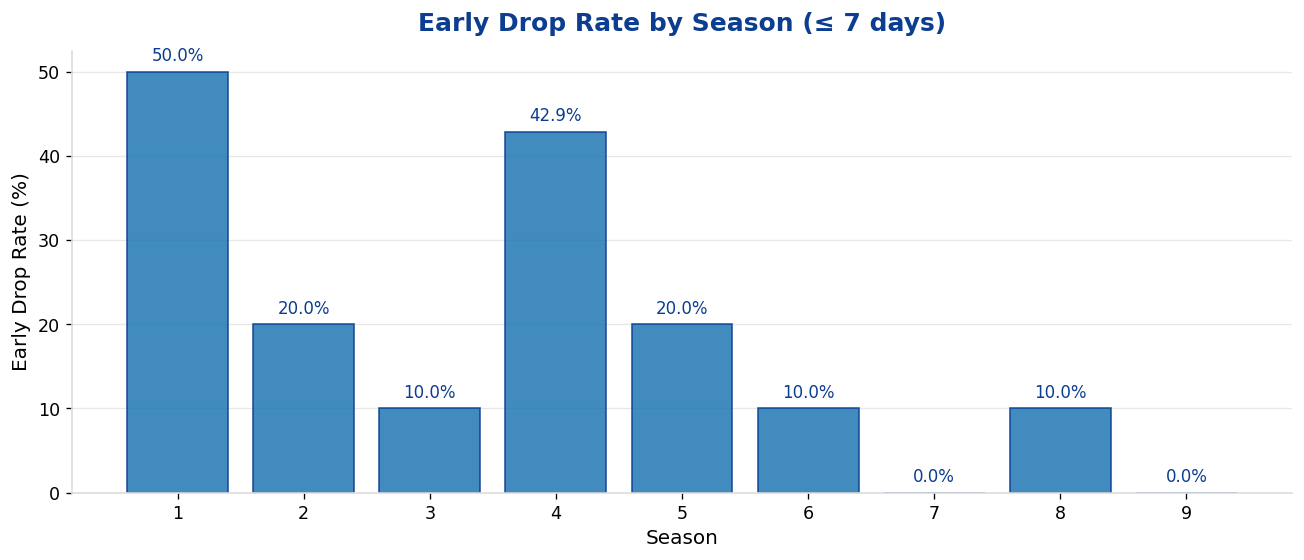

,early_drop_%
season,
1,50.000000
2,20.000000
3,10.000000
4,42.857143
5,20.000000
6,10.000000
7,0.000000
8,10.000000
9,0.000000


In [ ]:
early_cut = 7

tmp = survivalists.copy()
tmp["days_lasted"] = pd.to_numeric(tmp["days_lasted"], errors="coerce")
tmp = tmp.dropna(subset=["season", "days_lasted"])

early_rate = (tmp.groupby("season")["days_lasted"]
               .apply(lambda s: (s <= early_cut).mean())
               .sort_index() * 100)

fig, ax = plt.subplots(figsize=(11, 4.8), dpi=120)
ax.bar(early_rate.index.astype(str), early_rate.values, color=BLUE, alpha=0.85, edgecolor=BLUE_DARK, linewidth=1.0)

polish_ax(
    ax,
    title=f"Early Drop Rate by Season (≤ {early_cut} days)",
    xlabel="Season",
    ylabel="Early Drop Rate (%)"
)

for i, v in enumerate(early_rate.values):
    ax.text(i, v + 0.8, f"{v:.1f}%", ha="center", va="bottom", fontsize=10, color=BLUE_DARK)

plt.tight_layout()
plt.show()

display(early_rate.rename("early_drop_%").to_frame())

**EDA Insights — Early Drop Rate (≤ 7 Days)**

- Early exits vary sharply across seasons, indicating strong **imbalance in initial survival outcomes**.
- Some seasons experience high early drop rates, while others show near-zero early exits, suggesting **season-level conditions or shocks** strongly affect early survival.
- This pattern implies distinct early-failure regimes rather than a uniform attrition process.

##EDA 2 — Strategy Under Constraint

Each survivalist is allowed to bring exactly 10 items, so analytical emphasis shifts from “how many items” to composition and strategy choice.

In [ ]:
item_counts = (
    loadouts["item"]
    .value_counts()
    .rename("count")
    .to_frame()
)

item_counts.head(10)


,count
item,
Pot,92
Fishing gear,90
Sleeping bag,85
Axe,80
Saw,80
Ferro rod,77
Rations,68
Bow and arrows,60
Paracord,56


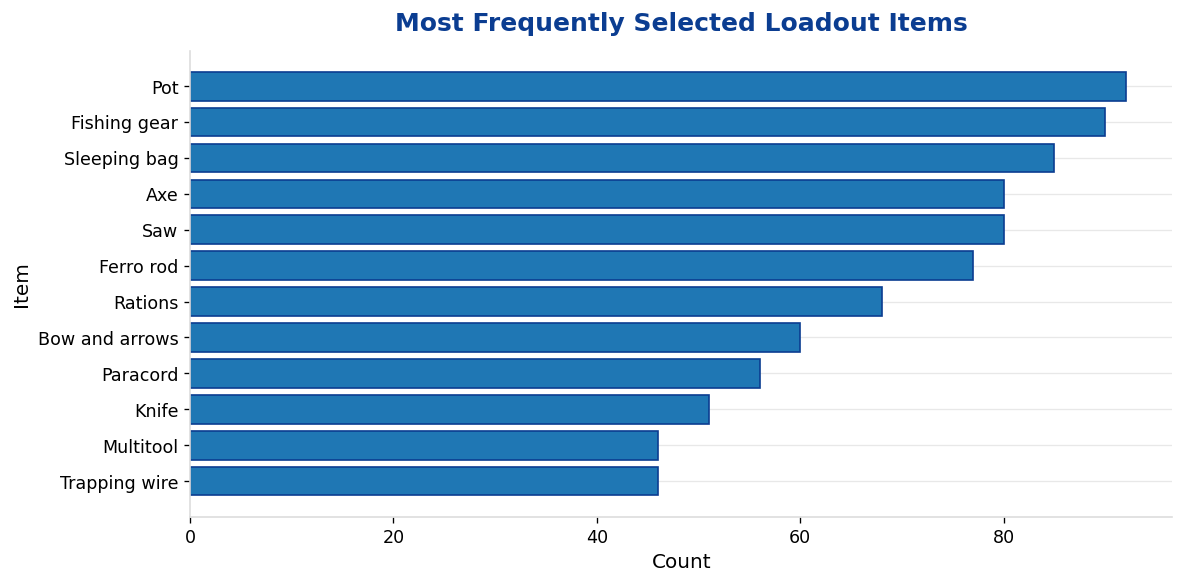

In [ ]:
top_items = item_counts.head(12)

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(
    top_items.index[::-1],
    top_items["count"][::-1],
    color=BLUE,
    edgecolor=BLUE_DARK
)

polish_ax(
    ax,
    title="Most Frequently Selected Loadout Items",
    xlabel="Count",
    ylabel="Item"
)

plt.tight_layout()
plt.show()


**EDA Insights — Most Frequently Selected Loadout Items**

- A small set of core items dominates selection frequency, indicating **strong consensus around essential survival tools**.
- Despite this concentration, no single item is universally chosen, suggesting **meaningful strategic variation** in loadout composition.
- The presence of multiple high-frequency items implies that **combinations of tools**, rather than individual items alone, may differentiate survival strategies.

##EDA 3 — Audience Engagement

To connect the project to business relevance, we examine episode-level engagement metrics:

* Viewership (millions) as a proxy for audience reach

* IMDb rating as a proxy for perceived episode quality

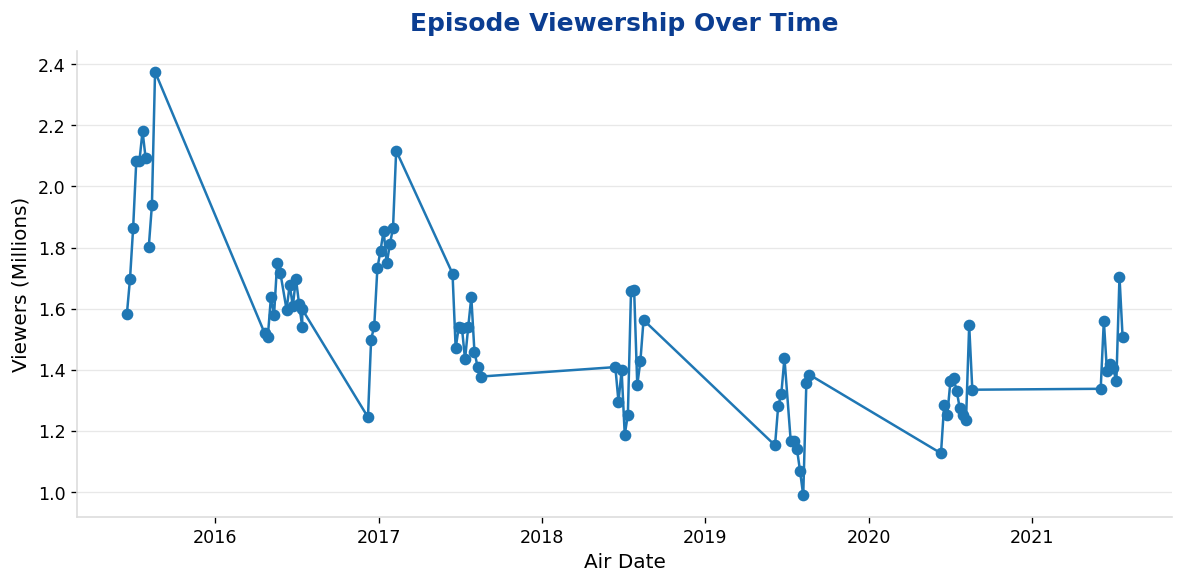

In [ ]:
episodes_sorted = episodes.sort_values("air_date")

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(
    episodes_sorted["air_date"],
    episodes_sorted["viewers"],
    marker="o",
    color=BLUE
)

polish_ax(
    ax,
    title="Episode Viewership Over Time",
    xlabel="Air Date",
    ylabel="Viewers (Millions)"
)

plt.tight_layout()
plt.show()


**EDA Insights — Episode Viewership Over Time**

- Episode viewership shows a **general downward trend over time**, with noticeable fluctuations across seasons.
- Short-term spikes and dips suggest **episodic shocks or season-specific effects**, rather than smooth audience decay.
- Partial stabilization in later seasons indicates that audience engagement may **recover or adapt** despite long-term decline.

/tmp/ipython-input-576420720.py:10: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(


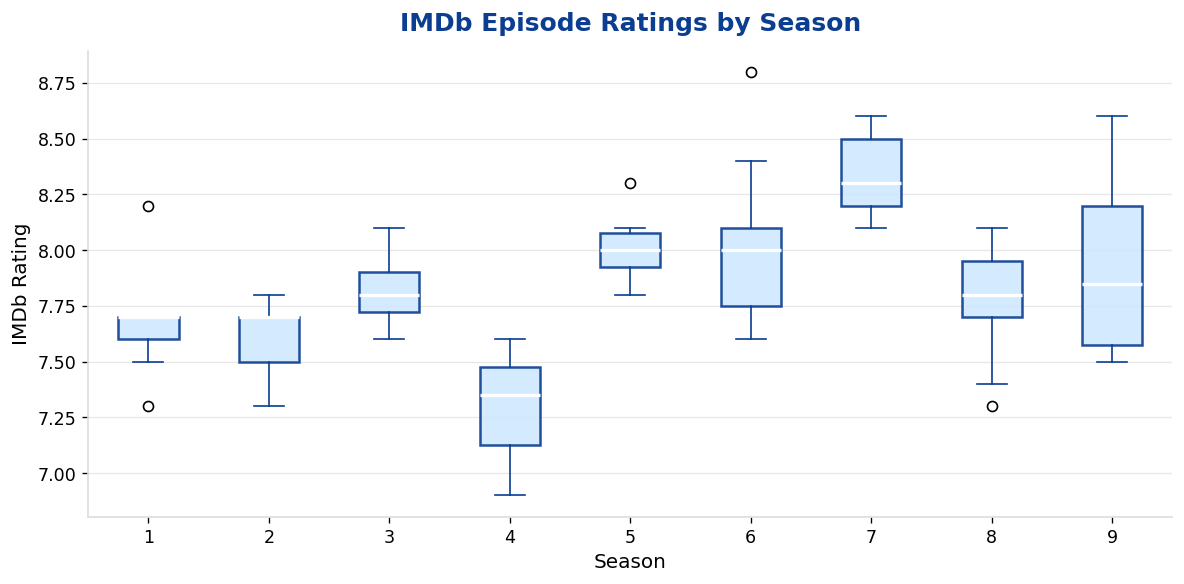

In [ ]:
ep = episodes.copy()
ep["imdb_rating"] = pd.to_numeric(ep["imdb_rating"], errors="coerce")
ep = ep.dropna(subset=["season", "imdb_rating"])

season_order = sorted(ep["season"].unique())
data = [ep.loc[ep["season"] == s, "imdb_rating"].values for s in season_order]

fig, ax = plt.subplots(figsize=(10, 5), dpi=120)

bp = ax.boxplot(
    data,
    labels=[str(s) for s in season_order],
    patch_artist=True,
    medianprops=dict(color="white", linewidth=2),
    boxprops=dict(edgecolor=BLUE_DARK, linewidth=1.5),
    whiskerprops=dict(color=BLUE_DARK),
    capprops=dict(color=BLUE_DARK),
)

for box in bp["boxes"]:
    box.set_facecolor(BLUE_LIGHT)
    box.set_alpha(0.9)

polish_ax(
    ax,
    title="IMDb Episode Ratings by Season",
    xlabel="Season",
    ylabel="IMDb Rating"
)

plt.tight_layout()
plt.show()

**EDA Insights — IMDb Episode Ratings by Season**

- Episode ratings differ across seasons, with some seasons showing consistently higher medians and tighter spreads, while others exhibit lower central tendency and greater variability.
- A small number of outlier episodes achieve unusually high ratings, suggesting **season-specific peaks in audience engagement** rather than uniformly strong reception.
- Overall, ratings are relatively concentrated within a narrow range, indicating stable baseline quality with **meaningful season-level deviations**.

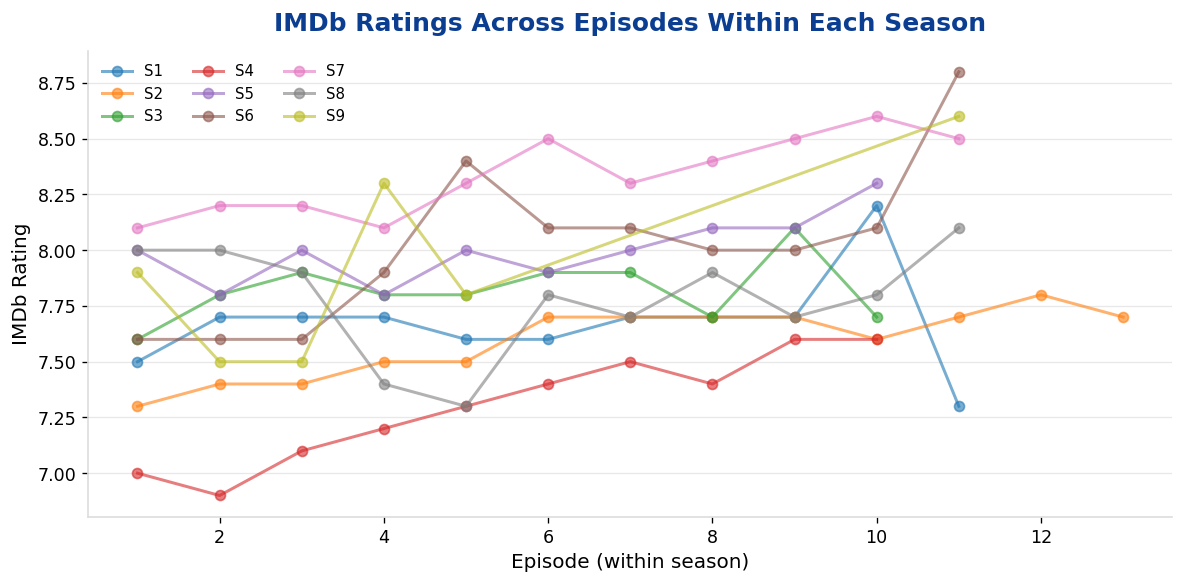

In [ ]:
ep = episodes.copy()
ep["imdb_rating"] = pd.to_numeric(ep["imdb_rating"], errors="coerce")
ep["episode"] = pd.to_numeric(ep["episode"], errors="coerce")
ep = ep.dropna(subset=["season", "episode", "imdb_rating"])

fig, ax = plt.subplots(figsize=(10, 5), dpi=120)

for s in sorted(ep["season"].unique()):
    sub = ep[ep["season"] == s].sort_values("episode")
    ax.plot(
        sub["episode"],
        sub["imdb_rating"],
        marker="o",
        alpha=0.6,
        linewidth=1.8,
        label=f"S{s}"
    )

polish_ax(
    ax,
    title="IMDb Ratings Across Episodes Within Each Season",
    xlabel="Episode (within season)",
    ylabel="IMDb Rating"
)

ax.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()

**EDA Insights — IMDb Ratings Across Episodes Within Each Season**

- Within-season rating trajectories are heterogeneous: some seasons display gradual improvement across episodes, while others fluctuate without a clear trend.
- Several seasons show **late-episode rating peaks**, suggesting increasing engagement as the season progresses.
- The absence of a uniform episode-level pattern across seasons indicates that **viewer response dynamics vary by season**, rather than following a single episodic progression model.